## Import Libs

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
import xgboost as xgb
from sklearn import metrics
from scipy.stats import skew
import keras
from datetime import datetime

from IPython.display import Audio
%matplotlib inline

Using TensorFlow backend.


## Helper Functions

In [2]:
def convertNA(value):
    try:
        if np.isnan(value):
            return "None"
        else:
            return value
    except:
        return value

In [3]:
def makeSubmission(subType,predictions,testDF):
    submission = pd.DataFrame()
    submission["Id"] = testDF["Id"]
    submission["SalePrice"] = predictions
    submission.to_csv("../assets/submission_"+subType+"_"+ datetime.now().strftime("%Y%m%d-%H%M%S") +".csv", index=False)

In [4]:
def rmsle(y_predict,y_actual):
    return np.sqrt(np.mean(np.power(np.log1p(y_predict) - np.log1p(y_actual), 2)))

## Read, Clean, Create Dummies

In [48]:
train  = pd.read_csv("../assets/train.csv")
test = pd.read_csv("../assets/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

categories = [u"Alley","Fence","PoolQC","GarageCond","GarageQual","GarageFinish","MiscFeature","GarageType","FireplaceQu","BsmtFinType2","BsmtFinType1","BsmtCond","BsmtQual"]
for column in categories:
    all_data[column] = all_data[column].apply(convertNA)

all_data.fillna(all_data.mean(),inplace=True)

all_data = pd.get_dummies(all_data)

X = all_data.iloc[:1460,:]
X_test = all_data.iloc[1460:,:]
y = train["SalePrice"]

all_data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.000000,8450,7,5,2003,2003,196.0,706.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,80.000000,9600,6,8,1976,1976,0.0,978.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,68.000000,11250,7,5,2001,2002,162.0,486.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,60.000000,9550,7,5,1915,1970,0.0,216.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.000000,14260,8,5,2000,2000,350.0,655.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,50,85.000000,14115,5,5,1993,1995,0.0,732.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,20,75.000000,10084,8,5,2004,2005,186.0,1369.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,60,69.305795,10382,7,6,1973,1973,240.0,859.0,32.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,50,51.000000,6120,7,5,1931,1950,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,190,50.000000,7420,5,6,1939,1950,0.0,851.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Create Functions for Each Model Type

### Random Forest

In [ ]:
def runRFModel(X,y,X_test):
    cv = KFold(len(y),shuffle=False)
    rf = RandomForestRegressor(random_state=5)
    rfScore = cross_val_score(rf,X,y,cv=cv, n_jobs=-1)
    model = rf.fit(X,y)

    predictions =  model.predict(X)
    print "Score: ", metrics.r2_score(y,predictions)
    print "RMSLE: ", rmsle(y,predictions)

    return predictions,model.predict(X_test)
    

### XGBoost

In [ ]:
def modelfit(alg, X, X_test, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtest_predictions = alg.predict(X_test)
    
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    #Print model report:
    #print "\nModel Report"
    #print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['SalePrice'].values.astype(float), dtrain_predictions.astype(float))
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['SalePrice'], dtrain_predprob)
    #print "Score: ", metrics.r2_score(y,dtrain_predictions)
    #print "RMSLE: ", rmsle(y,dtrain_predictions)
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')


In [ ]:
def runXGB(X,y,X_test):
    xgb1 = xgb.XGBRegressor(
     learning_rate =0.01,
     n_estimators=1000,
     max_depth=6,
     min_child_weight=3,
     gamma=0,
     subsample=0.65,
     colsample_bytree=0.65,
     objective= 'reg:linear',
     nthread=4,
     scale_pos_weight=1,
     reg_alpha= 1e-05,
     seed=27)
    model = modelfit(xgb1, X, X_test, y)

    predictions =  xgb1.predict(X)
    print "Score: ", metrics.r2_score(y,predictions)
    print "RMSLE: ", rmsle(y,predictions)

    return predictions, xgb1.predict(X_test)

### Linear Regression (Lasso)

In [ ]:
def runLinReg(X,y,X_test):
    #log transform the target:
#     y = np.log1p(y)

    #log transform skewed numeric features:
#     numeric_feats = X.dtypes[X.dtypes != "object"].index

#     skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#     skewed_feats = skewed_feats[skewed_feats > 0.75]
#     skewed_feats = skewed_feats.index
    
#     skewed_feats_test = X_test[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#     skewed_feats_test = skewed_feats_test[skewed_feats_test > 0.75]
#     skewed_feats_test = skewed_feats_test.index

#     X[skewed_feats] = np.log1p(X[skewed_feats])
#     X_test[skewed_feats_test] = np.log1p(X_test[skewed_feats_test])
    
    model_lasso = LassoCV(cv=1000,alphas = [100,10,1, 0.1, 0.001, 0.0005], max_iter = 50000, verbose = 1, n_jobs=-2).fit(X, y)
    
    predictions =  model_lasso.predict(X)
    print "Score: ", metrics.r2_score(y,predictions)
    print "RMSLE: ", rmsle(y,predictions)

    return predictions, model_lasso.predict(X_test)

## Build the models and make predictions

In [ ]:
rf_predictions,rf_predictions_test = runRFModel(X,y,X_test)
Audio(url="../assets/beep-09.mp3",autoplay=True)

In [ ]:
xgb_predictions,xgb_predictions_test = runXGB(X,y,X_test)
Audio(url="../assets/beep-09.mp3",autoplay=True)

In [ ]:
lr_predictions,lr_predictions_test = runLinReg(X,y,X_test)
Audio(url="../assets/beep-09.mp3",autoplay=True)

## Save Predictions

In [ ]:
level1 = pd.DataFrame()
# level1["rf"] = np.log1p(rf_predictions)
# level1["xgb"] = np.log1p(xgb_predictions)
level1["rf"] = rf_predictions
level1["xgb"] = xgb_predictions
level1["lr"] = lr_predictions
level1["y"] = y
level1.head()

In [ ]:
level1_test = pd.DataFrame()
# level1_test["rf"] = np.log1p(rf_predictions_test)
# level1_test["xgb"] = np.log1p(xgb_predictions_test)
level1_test["rf"] = rf_predictions_test
level1_test["xgb"] = xgb_predictions_test
level1_test["lr"] = lr_predictions_test
level1_test.head()

In [ ]:
level1.to_csv("../assets/Level1.csv",index=False)
level1_test.to_csv("../assets/Level1_test.csv",index=False)

In [6]:
neural = pd.read_csv("../assets/Level1.csv")
neural.head(5)

,rf,xgb,lr,y
0,208400.0,204554.875000,207908.910335,208500
1,173000.0,176239.093750,197313.567788,181500
2,217000.0,214539.015625,212106.287983,223500
3,142400.0,153358.062500,180232.377505,140000
4,265309.0,272659.000000,298192.932965,250000


In [7]:
neural_test = pd.read_csv("../assets/Level1_test.csv")
neural_test.head(5)

,rf,xgb,lr
0,126480.0,127040.242188,116297.300806
1,151420.0,156986.437500,147684.873639
2,183290.0,183298.046875,182011.842679
3,184283.2,190673.109375,194552.542945
4,197240.0,189672.546875,207450.365053


In [8]:
net_X = neural.values[:,0:3]
net_Y = neural.values[:,3]

## Construct Neural Net

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

# define base mode
def baseline_model_mse():
    # create model
    model = Sequential()
    model.add(Dense(3, input_dim=3, init='normal', activation='relu'))
    #model.add(Dense(2, input_dim=2, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

def baseline_model_msle():
    # create model
    model = Sequential()
    model.add(Dense(3, input_dim=3, init='normal', activation='relu'))
    #model.add(Dense(2, input_dim=2, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='msle', optimizer='adam')
    return model


def deeper_model():
    # create model
    model = Sequential()
    model.add(Dense(3, input_dim=3, init='normal', activation='relu'))
    model.add(Dense(3, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(6, input_dim=3, init='normal', activation='relu'))
    #model.add(Dense(2, input_dim=2, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

def deeper_wider_model():
    # create model
    model = Sequential()
    model.add(Dense(6, input_dim=3, init='normal', activation='relu'))
    model.add(Dense(3, init='normal', activation='relu'))
    #model.add(Dense(2, input_dim=2, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

In [10]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## NN Optimization

### Base + MSE

In [11]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model_mse, nb_epoch=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n=len(net_X), n_folds=10, random_state=seed)
results = cross_val_score(pipeline, net_X, net_Y, cv=kfold,n_jobs=1)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
Audio(url="../assets/beep-09.mp3",autoplay=True)


Results: 16024461638.59 (19626944334.10) MSE


### Base + MSLE

In [13]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model_msle, nb_epoch=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n=len(net_X), n_folds=10, random_state=seed)
results = cross_val_score(pipeline, net_X, net_Y, cv=kfold,n_jobs=1)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
Audio(url="../assets/beep-09.mp3",autoplay=True)

Results: 43.53 (66.49) MSE


In [ ]:
print "Base", np.sqrt(results.mean())

### Standardized

In [14]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model_mse, nb_epoch=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n=len(net_X), n_folds=10, random_state=seed)
results = cross_val_score(pipeline, net_X, net_Y, cv=kfold,n_jobs=1)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
standardized = np.sqrt(results.mean())
Audio(url="../assets/beep-09.mp3",autoplay=True)

Results: 37356689387.66 (3530684844.23) MSE


In [16]:
print "Improvement Over Base", base - wider

-21332227749.070004

### Deeper

In [18]:
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=deeper_model, nb_epoch=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n=len(net_X), n_folds=10, random_state=seed)
results = cross_val_score(pipeline, net_X, net_Y, cv=kfold,n_jobs=1)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
deeper = np.sqrt(results.mean())
Audio(url="../assets/beep-09.mp3",autoplay=True)

Results: 3562899489.32 (10506171269.32) MSE


In [20]:
print "Improvement Over Base", base - deeper

111631.36722834672

### Wider

In [21]:
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, nb_epoch=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n=len(net_X), n_folds=10, random_state=seed)
results = cross_val_score(pipeline, net_X, net_Y, cv=kfold,n_jobs=1)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
wider = np.sqrt(results.mean())
Audio(url="../assets/beep-09.mp3",autoplay=True)

Results: 60288966.56 (10529511.61) MSE


In [23]:
16024461638.59 - 60288966.56 

15964172672.03

In [22]:
print "Improvement Over Base", base - wider

Improvement Over Base

NameError: name 'base' is not defined

## Combined

In [25]:
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, nb_epoch=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n=len(net_X), n_folds=10, random_state=seed)
results = cross_val_score(pipeline, net_X, net_Y, cv=kfold,n_jobs=1)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
deeperAndWider = np.sqrt(results.mean())
Audio(url="../assets/beep-09.mp3",autoplay=True)

Results: 60957796.59 (9311079.41) MSE


In [26]:
print "Improvement Over Base", base - deeperAndWider

Improvement Over Base

NameError: name 'base' is not defined

In [27]:
16024461638.59 - 60957796.59

15963503842.0

In [ ]:
15964172672.03

## Train  Optimized Neural Net

In [ ]:
# scale = StandardScaler()
# net_X = scale.fit_transform(net_X)

nnRegressor = KerasRegressor(build_fn=baseline_model, nb_epoch=200, batch_size=5,verbose=0)

nnRegressor.fit(net_X,net_Y)
outsample_predictions = nnRegressor.predict(neural_test.values)
insample_predictions  = clf.predict(net_X)

Audio(url="../assets/beep-09.mp3",autoplay=True)

## NN Evaluation

In [29]:
model = pipeline.fit(net_X,net_Y)

In [30]:
model.score(net_X,net_Y)

61853261.33219178

In [31]:
flat_insample_predictions = model.predict(net_X).flatten()

In [47]:
print "Stacked Model: ", rmsle(flat_insample_predictions,net_Y)
print "RF Model:      ", rmsle(neural["rf"],net_Y)
print "XGB Model:     ", rmsle(neural["xgb"],net_Y)
print "LR Model:      ", rmsle(neural["lr"],net_Y)

Stacked Model:  0.0509024801977
RF Model:       0.0700630523153
XGB Model:      0.0547475082587
LR Model:       0.119348814341


In [33]:
pd.DataFrame({"y_hat":flat_insample_predictions,"y_actual":net_Y})

,y_actual,y_hat
0,208500.0,202630.703125
1,181500.0,170045.890625
2,223500.0,213481.328125
3,140000.0,145125.656250
4,250000.0,264156.531250
5,143000.0,144339.359375
6,307000.0,300185.593750
7,200000.0,206147.687500
8,129900.0,127525.718750
9,118000.0,123749.007812


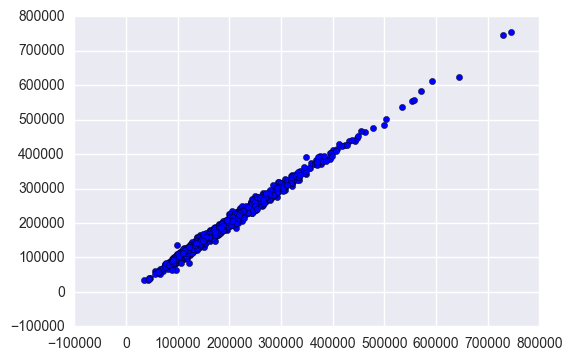

In [35]:
plt.scatter(flat_insample_predictions,net_Y)

## Make Submission File

In [44]:
outsample_predictions = model.predict(neural_test.values)

In [45]:
makeSubmission("stacked_deep_wide",outsample_predictions,test)